# Explanation of the FiniteElementVaryY2DMeshConstructor
This file presents a step-by-step application of the `sfsimodels.num.mesh.FiniteElementVaryY2DMeshConstructor`
to an `sfsimodels.TwoDSystem`.

## Import python libraries for displaying images

In [8]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import sfsimodels as sm
from sfsimodels.num import mesh
import numpy as np
import o3plot
import pyqtgraph.exporters

# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

## Define a two dimensional system
The system consists of two soil profiles with angled layers, a surface ground slope and a
building with an embedded foundation.

22.0 1.8


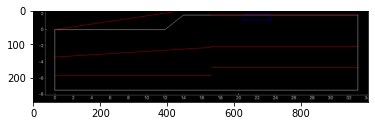

In [6]:
vs = 150.0
rho = 1.8
g_mod = vs ** 2 * rho

sl1 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.32)
sl2 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.33)
sl3 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.34)
sl4 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.35)
sl5 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.36)
sp = sm.SoilProfile()
h_face = 1.8
sp.add_layer(0, sl1)
sp.add_layer(3.4, sl2)
sp.add_layer(5.7, sl3)
sp2 = sm.SoilProfile()
sp2.add_layer(0, sl4)
sp2.add_layer(3.9, sl2)
sp2.add_layer(6.5, sl5)
sp2.height = 20
sp.x_angles = [0.17, 0.07, 0.0]
sp2.x_angles = [0.0, 0.00, 0.0]

fd = sm.RaftFoundation()
fd.width = 3
fd.depth = 0.6
fd.ip_axis = 'width'
fd.height = 0.7
fd.length = 100
tds = sm.TwoDSystem(width=33, height=7.5)
tds.add_sp(sp, x=0)
tds.add_sp(sp2, x=17)
tds.x_surf = np.array([0, 12, 14, tds.width])
tds.y_surf = np.array([0, 0, h_face, h_face])
bd = sm.NullBuilding()
bd.set_foundation(fd, x=0.0)
tds.add_bd(bd, x=22)

x_scale_pos = np.array([0, 5, 10, 16, 19, 25, 29])
x_scale_vals = np.array([2., 1.2, 1.0, 1.2, 0.7, 1.2, 2])
win = o3plot.create_scaled_window_for_tds(tds, title='ECP definition')
o3plot.plot_two_d_system(win, tds)
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Initialise the constructor
The constructor is given four primary inputs:
 - `tds`: an `sfsimodels.TwoDSystem`
 - `dy_target`: `float` which defines the target height of each element
 - `x_scale_pos`: `array_like`, defining positions from the left edge, where the element width should change size
 - `x_scale_vals`: `array_like`, defining the scale between the target element height and target element width at
 each zone between the `x_scale_pos` points

The `auto_run` parameter is also set to `False` to allow each step to be run individually.

In [9]:
# Initial the constructor
fc = mesh.FiniteElementVaryY2DMeshConstructor(tds, 0.5, x_scale_pos=x_scale_pos,
                                                       x_scale_vals=x_scale_vals, auto_run=False)

## Step 1: Find the import coordinates and slopes in the 2D system
This includes layer boundaries, foundation corners, and surface slopes that should be
maintained in the FE mesh

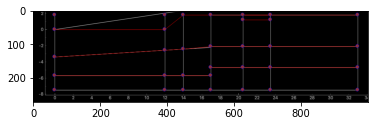

In [14]:
fc.get_special_coords_and_slopes()

# plot the model state
win = o3plot.create_scaled_window_for_tds(tds, title='get_special_coords_and_slopes')
y_sps_surf = np.interp(tds.x_sps, tds.x_surf, tds.y_surf)
for i in range(len(tds.sps)):
    x0 = tds.x_sps[i]
    if i == len(tds.sps) - 1:
        x1 = tds.width
    else:
        x1 = tds.x_sps[i + 1]
    xs = np.array([x0, x1])
    x_angles = list(tds.sps[i].x_angles)
    sp = tds.sps[i]
    for ll in range(1, sp.n_layers + 1):
        ys = y_sps_surf[i] - sp.layer_depth(ll) + x_angles[ll - 1] * (xs - x0)
        win.plot(xs, ys, pen='w')
for i in range(len(fc.sds)):
    win.plot(fc.sds[i][0], fc.sds[i][1], pen='b')
win.plot([0, fc.tds.width], [-fc.tds.height, -fc.tds.height], pen='w')
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    xn = xc * np.ones_like(list(fc.yd[xc]))
    win.plot(xn, list(fc.yd[xc]), symbol='o', symbolPen='r')
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()